In [1]:
import os
print(os.path.expanduser('~'))


C:\Users\movin


In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
from keras import backend as K
K.set_image_dim_ordering('tf') # note that we need to have tensorflow dimension ordering still because of the weigths.
print('The backend is:',K.backend())
import tensorflow as tf
print(K.image_dim_ordering()) # should say tf
print(tf.__version__)

Using TensorFlow backend.


The backend is: tensorflow
tf
1.4.0


In [4]:
# Import relevant packages
import h5py
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#from matplotlib import ticker
#import seaborn as sns
%matplotlib inline 

from PIL import Image

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, ZeroPadding2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import model_from_json
from keras.preprocessing import image

from IPython.display import Image, display

# fix random seed for reproducibility
seed = 150
np.random.seed(seed)

In [5]:
# Load in and process data
!dir

 Volume in drive C is OS
 Volume Serial Number is BE81-1D82

 Directory of C:\Users\movin\data-x-team-project\Python

12/05/2017  01:28 PM    <DIR>          .
12/05/2017  01:28 PM    <DIR>          ..
12/04/2017  04:10 PM    <DIR>          .ipynb_checkpoints
12/05/2017  01:07 PM         8,403,628 catvsdogs_VGG16_pretrained_tf_top.h5
12/05/2017  01:15 PM            10,548 cnnmodel.ipynb
12/02/2017  11:16 PM    <DIR>          data
12/05/2017  10:13 AM       331,057,946 data.zip
12/05/2017  01:28 PM        81,920,096 features_test.npy
10/27/2017  04:37 PM               615 Flickr.ipynb
10/27/2017  03:59 PM            36,391 minimodel.ipynb
12/05/2017  01:08 PM             1,292 mod_appendix.json
11/21/2017  11:55 AM            26,374 nlpmodel.ipynb
12/04/2017  10:24 PM        58,889,256 vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
12/05/2017  01:08 PM         4,879,872 w_appendix.h5
              10 File(s)    485,226,018 bytes
               4 Dir(s)  171,246,055,424 bytes free


In [6]:
# Look at files, note all E images and I images are unique
from __future__ import absolute_import, division, print_function # make it compatible w Python 2
import os
for path, dirs, files in os.walk('./data'):
    print('FOLDER',path)
    for f in files[:4]:
        print(f)

FOLDER ./data
FOLDER ./data\test
FOLDER ./data\test\EvI
10214769505696272.jpg
10214769648783681.jpg
10214771823355944.jpg
10214776387874198.jpg
FOLDER ./data\train
FOLDER ./data\train\E
114634502635280.jpg
115446745886429.jpg
119371252160555.jpg
121041068588910.jpg
FOLDER ./data\train\I
103955050372901.jpg
106101140156824.jpg
107729153327634.jpg
111430939623126.jpg
FOLDER ./data\validation
FOLDER ./data\validation\E
114634502635280.jpg
122737501776766.jpg
132584087463634.jpg
132867420802701.jpg
FOLDER ./data\validation\I
1001091583356351.jpg
1004190739722068.jpg
1010717142403190.jpg
1011847008955121.jpg


In [7]:
print('Number of E training images:', len(next(os.walk('./data/train/E'))[2]))
print('Number of I training images:', len(next(os.walk('./data/train/I'))[2]))
print('Number of E validation images:', len(next(os.walk('./data/validation/E'))[2]))
print('Number of I validation images:', len(next(os.walk('./data/validation/I'))[2]))
print('Number of uncategorized test images:', len(next(os.walk('./data/test/EvI'))[2]))

Number of E training images: 100
Number of I training images: 100
Number of E validation images: 50
Number of I validation images: 50
Number of uncategorized test images: 16


In [8]:
# Define variables
TRAIN_DIR = './data/train/'
VAL_DIR = './data/validation/'
TEST_DIR = './data/test/' #one mixed category

img_width, img_height = 150, 150

n_train_samples = 200
n_validation_samples = 100
n_epoch = 30
n_test_samples = 16

In [36]:
# Function for saving bottleneck features
# This can take ~20mins to run

#  Run model once to record the bottleneck features using image data generators:

def save_bottleneck_features():

    from keras import applications
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet', \
                                     input_tensor=None, input_shape=(img_width, img_height,3))
    
    print('TensorFlow VGG16 model architecture loaded')
    
    # include_top = False, because we drop last layer, then we also only need to
    # download weight file that is small
    # input_shape with channels last
    
    
    # Rescale value we multiply the data before any other processing. 
    # Our original images consist in RGB coefficients in the 0-255, 
    # but such values would be too high for our models to process (given typical learning rate), 
    # so we target values between 0 and 1 instead by scaling with a 1/255. factor.
    datagen = ImageDataGenerator(rescale=1./255)
    
    def generate_features(DIR,n_samples,name_str):
       
        '''This is a generator that will read pictures found in
        subfolers of 'data/*', and indefinitely generate
        batches of image rescaled images used to predict
        the bottleneck features of the images once
        using model.predict_generator(**args**)'''

        print('Generate '+name_str+' image features')

        generator = datagen.flow_from_directory(
            DIR,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None, # this means our generator will only yield batches of data, no labels
            shuffle=False)
        
        features = model.predict_generator(generator, steps=len(generator))
        # the predict_generator method returns the output of a model, given
        # a generator that yields batches of numpy data
        
        np.save('features_'+name_str+'.npy', features) # save bottleneck features to file
    
    generate_features(TEST_DIR, n_test_samples, 'test')
    generate_features(VAL_DIR, n_validation_samples, 'validation')
    generate_features(TRAIN_DIR, n_train_samples, 'train')
    
    print('\nDone! Bottleneck features have been saved')


print('This step takes a long time to run.')
save_bottleneck_features()

This step takes a long time to run.
TensorFlow VGG16 model architecture loaded
Generate test image features
Found 16 images belonging to 1 classes.
Generate validation image features
Found 100 images belonging to 2 classes.
Generate train image features
Found 200 images belonging to 2 classes.

Done! Bottleneck features have been saved


In [37]:
# Extra
# Obtain class labels and binary classification for validation data
datagen = ImageDataGenerator(rescale=1./255)
val_gen = datagen.flow_from_directory(VAL_DIR,target_size=(img_width, img_height),
                                        batch_size=32,class_mode=None,shuffle=False)

val_labels = val_gen.classes

print('\nClassifications:\n',val_gen.class_indices)
print('\nClass labels:\n',val_labels)

Found 100 images belonging to 2 classes.

Classifications:
 {'E': 0, 'I': 1}

Class labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [38]:
train_data = np.load('features_train.npy')
train_data.shape

(200, 4, 4, 512)

In [39]:
validation_data = np.load('features_validation.npy')
validation_data.shape

(100, 4, 4, 512)

In [40]:
# Load in bottleneck features
# Run the code below to train your CNN with the training data

def train_model():
    train_data = np.load('features_train.npy')
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array([0] * (n_train_samples // 2) + [1] * (n_train_samples // 2))

    validation_data = np.load('features_validation.npy')
    # same as val_labels above
    validation_labels = np.array([0] * (n_validation_samples // 2) + [1] * (n_validation_samples // 2))

    # Add top layers trained ontop of extracted VGG features
    # Small fully connected model trained on top of the stored features
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    '''
    #We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. 
    #To go with it we will also use the binary_crossentropy loss to train our model.

    '''
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=n_epoch, batch_size=32,
              validation_data=(validation_data, validation_labels),
              shuffle=True) # fit the model

    # Save weights to disk

    # Save model architecture to disk
    model_json = model.to_json()
    with open("mod_appendix.json", "w") as json_file: # save model
        json_file.write(model_json)
    
    # Save model weights
    model.save_weights("EvI_VGG16_pretrained_tf_top.h5") # save weights
    print("Saved model to disk")
    print('Done!')
    
    return(model)
    
model = train_model()

Train on 200 samples, validate on 100 samples
Epoch 1/30
200/200 [==============================] - 1s 3ms/step - loss: 3.6301 - acc: 0.5550 - val_loss: 0.8199 - val_acc: 0.5300
Epoch 2/30
200/200 [==============================] - 0s 1ms/step - loss: 1.6152 - acc: 0.5250 - val_loss: 1.0212 - val_acc: 0.4800
Epoch 3/30
200/200 [==============================] - 0s 2ms/step - loss: 1.2201 - acc: 0.5350 - val_loss: 1.4173 - val_acc: 0.5000
Epoch 4/30
200/200 [==============================] - 0s 1ms/step - loss: 0.8416 - acc: 0.6400 - val_loss: 1.7785 - val_acc: 0.5000
Epoch 5/30
200/200 [==============================] - 0s 2ms/step - loss: 0.5969 - acc: 0.7150 - val_loss: 1.2781 - val_acc: 0.5000
Epoch 6/30
200/200 [==============================] - 0s 2ms/step - loss: 0.5639 - acc: 0.7150 - val_loss: 0.9788 - val_acc: 0.4900
Epoch 7/30
200/200 [==============================] - 0s 2ms/step - loss: 0.4362 - acc: 0.7800 - val_loss: 0.8507 - val_acc: 0.5700
Epoch 8/30
200/200 [==========

In [41]:
validation_data = np.load('features_validation.npy')

val_pred_class = model.predict_classes(validation_data,verbose=0) # predict image classes 
val_pred_prob = model.predict_proba(validation_data,verbose=0) # predict image probabilities

print('Accuracy on validation set: ',np.mean(val_pred_class.ravel()==val_labels)*100,'%')

print('\nVal loss & val_acc')
print(model.evaluate(validation_data,val_labels,verbose=0))
# First number is validation loss, loss of the objective function
# Second number validation accuracy

Accuracy on validation set:  52.0 %

Val loss & val_acc
[1.861767463684082, 0.52000000000000002]


In [42]:
# Alternative
print('Model accuracy on validation set:',model.evaluate(validation_data,val_labels,verbose=0)[1]*100,'%')

Model accuracy on validation set: 52.0 %


In [45]:
## Print try images:

# Use the model trained in Problem 1 to classify the test data images.
# Create a function that loads one image from the test data and then predicts
# if it is a cat or a dog and with what probability it thinks it is a cat or a dog
#
# Use variable test_data to make predictions
# Use list test_images to obtain the file name for all images (Note: test_images[0] corresponds to test_data[0])
# Use function plot_pic(img) to plot the image file

## Load in processed images feature to feed into bottleneck model

test_data = np.load('features_test.npy')

test_images =  [TEST_DIR+'EvI/'+img for img in os.listdir(TEST_DIR+'EvI/')]

def read_image(file_path):
    # For image visualization
    #im = np.array(Image.open(file_path))
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return img

def plot_pic(img):
    # Plot openCV pic
    pic = read_image(img)    
    plt.figure(figsize=(5,5))
    plt.imshow(pic)
    plt.show()



I think this is a E with 53.92983% probability


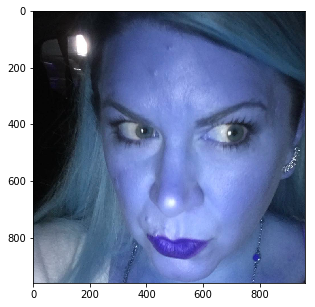



I think this is a I with 96.4937% probability


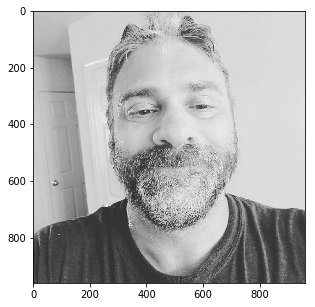



I think this is a E with 98.47537% probability


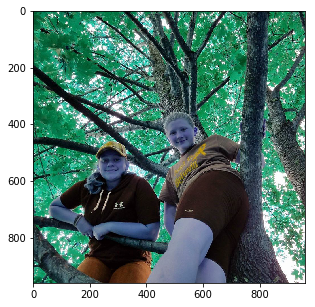



I think this is a I with 77.13752% probability


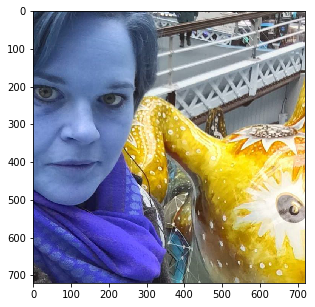



I think this is a I with 72.10218% probability


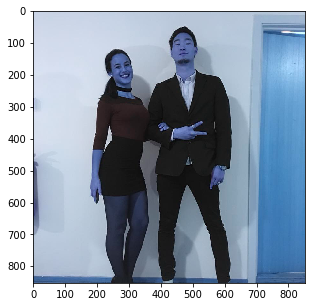



I think this is a I with 98.25904% probability


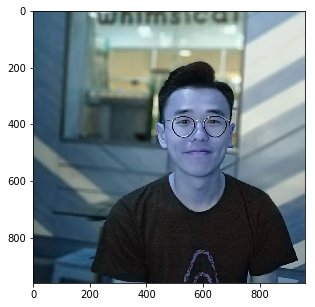



I think this is a E with 97.6718% probability


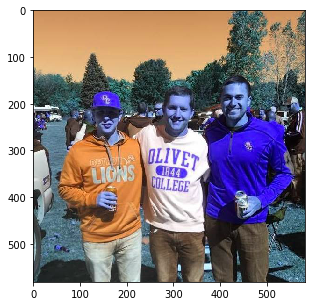



I think this is a I with 99.37437% probability


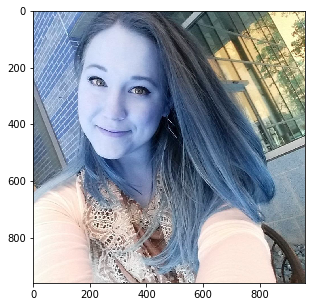



I think this is a I with 95.05344% probability


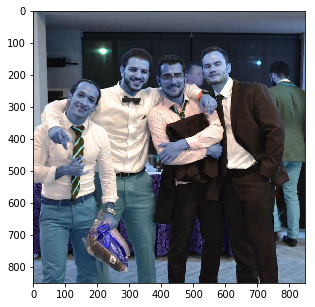



I think this is a E with 82.29938% probability


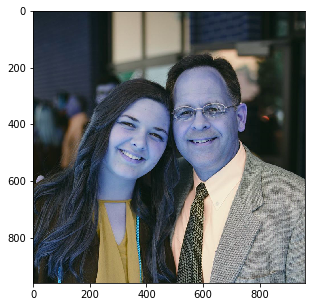



I think this is a E with 98.6588% probability


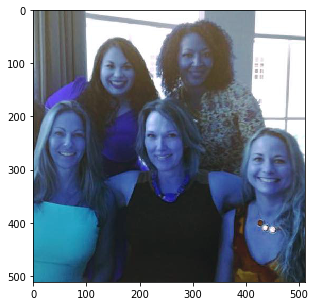



I think this is a I with 65.07092% probability


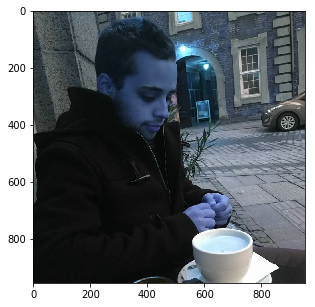



I think this is a E with 99.89788% probability


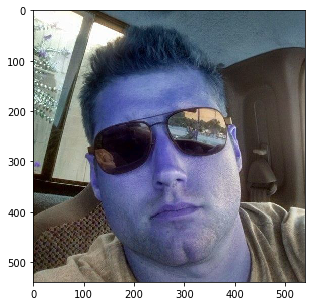



I think this is a E with 83.86825% probability


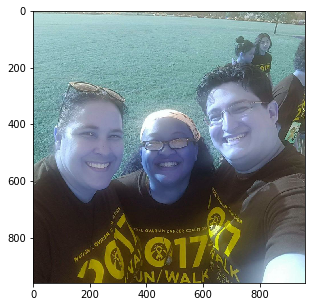



I think this is a E with 69.76392% probability


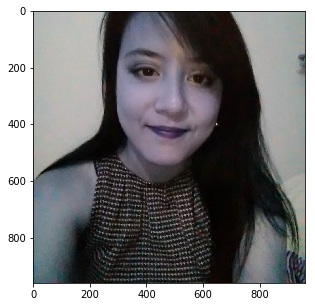



I think this is a I with 94.18968% probability


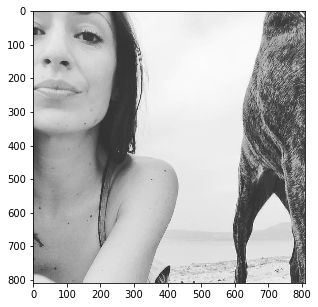

In [46]:
## Answer
import warnings
warnings.filterwarnings('ignore') # filter eventual warning

def predict(mod,i=0,r=None):
    if r==None:
        r=[i]
        
    for idx in r:
        class_pred = mod.predict_classes(test_data,verbose=0)[idx]
        prob_pred = mod.predict_proba(test_data,verbose=0)[idx]
        
        if class_pred ==0:
            prob_pred = 1-prob_pred
            class_guess='E'
        else:
            class_guess='I'
        
        print('\n\nI think this is a ' + class_guess + ' with ' +str(round(float(prob_pred)*100,5)) + '% probability')
        if test_images[idx]=='./data/test/EvI/.DS_Store':
            continue
        plot_pic(test_images[idx])

predict(model,r=range(0,len(test_data)))